In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

topics = pd.read_csv('data/topics.csv')
correlations = pd.read_csv('data/correlations.csv')
content_raw = pd.read_csv('data/content.csv')
content = content_raw.copy()

In [41]:
import os
from langchain_chroma import Chroma
from langchain_huggingface import HuggingFaceEndpointEmbeddings

# Get token
with open('token') as f:
    token = f.read()
os.environ["HUGGINGFACEHUB_API_TOKEN"] = token

# Create embedding calculator
embeddings = HuggingFaceEndpointEmbeddings(
    model="Qwen/Qwen3-Embedding-8B",
    task="feature-extraction",
)

# Load topic vector store
vector_store = Chroma(
    collection_name="topics",
    embedding_function=embeddings,
    persist_directory="data/vector_store",
)
retriever = vector_store.as_retriever(search_kwargs={'k': 5})

## Prepare topics

In [44]:
content_to_topic = {'content_id': [], 'topic_id': []}
for i, row in correlations.iterrows():
    for content_id in row['content_ids'].split(' '):
        content_to_topic['content_id'].append(content_id)
        content_to_topic['topic_id'].append(row['topic_id'])
content_to_topic = pd.DataFrame(content_to_topic)

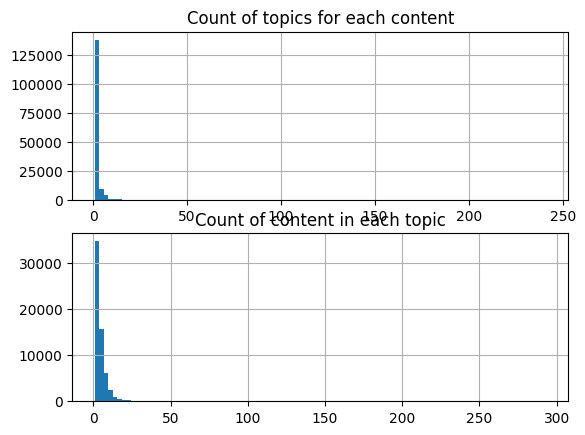

In [50]:
plt.subplot(2, 1, 1)
plt.title('Count of topics for each content')
content_to_topic.groupby('content_id')['topic_id'].count().hist(bins=100)
plt.subplot(2, 1, 2)
plt.title('Count of content in each topic')
content_to_topic.groupby('topic_id')['content_id'].count().hist(bins=100)
plt.show()

## Predictor

In [11]:
content.head()

,id,title,description,kind,text,language,copyright_holder,license
0,c_00002381196d,"Sumar números de varios dígitos: 48,029+233,930","Suma 48,029+233,930 mediante el algoritmo está...",video,NaN,es,NaN,NaN
1,c_000087304a9e,Trovare i fattori di un numero,Sal trova i fattori di 120.\n\n,video,NaN,it,NaN,NaN
2,c_0000ad142ddb,Sumar curvas de demanda,Cómo añadir curvas de demanda\n\n,video,NaN,es,NaN,NaN
3,c_0000c03adc8d,Nado de aproximação,Neste vídeo você vai aprender o nado de aproxi...,document,\nNado de aproximação\nSaber nadar nas ondas ...,pt,Sikana Education,CC BY-NC-ND
4,c_00016694ea2a,geometry-m3-topic-a-overview.pdf,geometry-m3-topic-a-overview.pdf,document,Estándares Comunes del Estado de Nueva York\n\...,es,Engage NY,CC BY-NC-SA


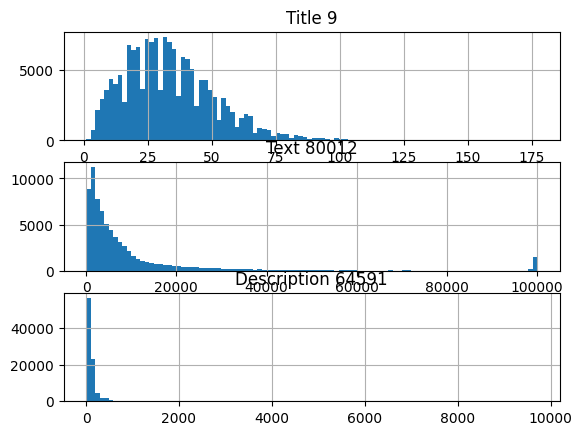

In [33]:
plt.subplot(3, 1, 1)
plt.title(f'Title {sum(content['title'].isna())}')
content['title'].str.len().hist(bins=100)
plt.subplot(3, 1, 2)
plt.title(f'Text {sum(content['text'].isna())}')
content['text'].str.len().hist(bins=100)
plt.subplot(3, 1, 3)
plt.title(f'Description {sum(content['description'].isna())}')
content['description'].str.len().hist(bins=100)
plt.show()

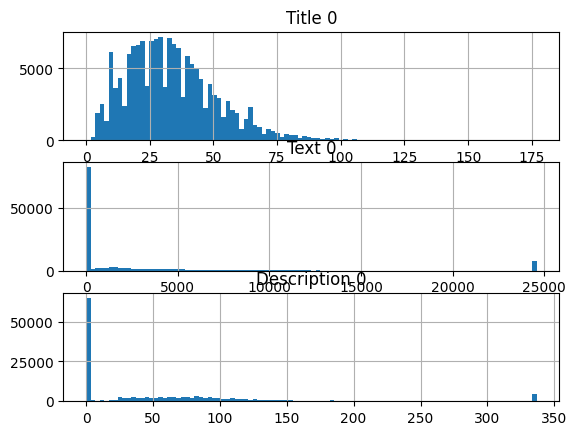

,title,description,text,language
id,,,,
c_00002381196d,"Sumar números de varios dígitos: 48,029+233,930","Suma 48,029+233,930 mediante el algoritmo está...",,es
c_000087304a9e,Trovare i fattori di un numero,Sal trova i fattori di 120.\n\n,,it
c_0000ad142ddb,Sumar curvas de demanda,Cómo añadir curvas de demanda\n\n,,es
c_0000c03adc8d,Nado de aproximação,Neste vídeo você vai aprender o nado de aproxi...,\nNado de aproximação\nSaber nadar nas ondas ...,pt
c_00016694ea2a,geometry-m3-topic-a-overview.pdf,geometry-m3-topic-a-overview.pdf,Estándares Comunes del Estado de Nueva York\n\...,es


In [40]:
# Clip length of content to decrease the size and make it manageable for the retriever
def clip_length(column, percentile=95):
    l_95 = np.percentile(column[column.notna()].str.len(), percentile)
    column = column.fillna('')
    column = column.map(lambda x: x[:int(l_95)])
    return column

content = content_raw.drop(columns=['kind', 'copyright_holder', 'license'])
content.index = content['id']
content = content.drop(columns=['id'])
content['title'] = content['title'].fillna('')
content['text'] = clip_length(content['text'], 90)
content['description'] = clip_length(content['description'])

plt.subplot(3, 1, 1)
plt.title(f'Title {sum(content['title'].isna())}')
content['title'].str.len().hist(bins=100)
plt.subplot(3, 1, 2)
plt.title(f'Text {sum(content['text'].isna())}')
content['text'].str.len().hist(bins=100)
plt.subplot(3, 1, 3)
plt.title(f'Description {sum(content['description'].isna())}')
content['description'].str.len().hist(bins=100)
plt.show()

content.head()

In [113]:
def retrieve(prompt, type):
    results = retriever.invoke(prompt)
    dicts = [r.metadata for r in results]
    for i, (r, d) in enumerate(zip(results, dicts)):
        d['score'] = 5 - i
        d['type'] = type
        d['name'] = r.page_content
    return pd.DataFrame(dicts)

def predict_content(row):
    language = row['language']
    all_results = None
    if row['title'] != '':
        all_results = retrieve(f'Topic of title: "{row['title']}"', 'title')
    if row['description'] != '':
        new_df = retrieve(f'Topic of description: "{row['description']}"', 'description')
        if all_results is not None:
            all_results = pd.concat([all_results, new_df])
    if row['description'] != '':
        new_df = retrieve(f'Topic of: "{row['text'][:1000]}"', 'text')
        if all_results is not None:
            all_results = pd.concat([all_results, new_df])
    all_results = all_results[['id', 'score']]
    all_results = all_results.groupby(['id'])['score'].sum() # Grouping by rank
    all_results = all_results.sort_values(ascending=False)
    joined = topics.set_index('id').join(all_results, how='right')
    # joined = joined[joined['language'] == language] # Filter by language
    joined = joined.iloc[:5] # Filter by language
    return joined

predict_content(content.sample().iloc[0])

,title,description,channel,category,level,language,parent,has_content,score
id,,,,,,,,,
t_e48b68ccd427,Cómo preparar los palés de madera,NaN,1cc2ee,source,3,es,t_df4cdfbbaf1b,True,10
t_58abd3e4a9dc,Introduction to Woodworking,NaN,73843d,source,3,en,t_4eed2b2b8558,True,9
t_808055995f3d,Preparing Pallets for Upcycling,NaN,73843d,source,3,en,t_db66c194c71e,True,8
t_05604d0161f6,Restyling Wood,NaN,73843d,source,3,en,t_db66c194c71e,True,5
t_db66c194c71e,Recycling Pallets,Build your own sustainable and trendy furnitur...,73843d,source,2,en,t_7ca16f372f02,False,5


## Predict dataset

In [117]:
from tqdm.notebook import tqdm

# Predict dataset
pred_results = {}
n = 1000
random_sample = content.sample(n)
for i, row in tqdm(random_sample.iterrows(), total=len(random_sample)):
    while True:
        try:
            pred = predict_content(row)
            pred_results[i] = pred
            break
        except Exception as e:
            continue


  0%|          | 0/1000 [00:00<?, ?it/s]

In [122]:
pred_dfs = []
for k, v in pred_results.items():
    temp_df = v.copy()
    temp_df['content_id'] = k
    temp_df['topic_id'] = temp_df.index
    temp_df = temp_df.reset_index(drop=True)
    pred_dfs.append(temp_df)
pred_df = pd.concat(pred_dfs)
pred_df.head()

,title,description,channel,category,level,language,parent,has_content,score,content_id,topic_id
0,Work-energy theorem,NaN,0ec697,source,4,en,t_48cea89450d0,True,5,c_fae000af5570,t_107d6bc83f12
1,Work-energy theorem,NaN,2ee29d,aligned,4,en,t_532cdfa2085c,True,4,c_fae000af5570,t_1379f1d82041
2,4.2 Work-energy theorem,NaN,e77b55,aligned,4,en,t_45dbcf35a31b,True,3,c_fae000af5570,t_5de671c07375
3,Work-energy theorem (Hindi),NaN,2ee29d,aligned,4,en,t_38dd668b2752,True,2,c_fae000af5570,t_a57df0b7f393
4,5.3 kinetic energy and the work Energy theorem,NaN,e77b55,aligned,4,en,t_2f20cf4e8f05,True,1,c_fae000af5570,t_c899a3e24e42


In [124]:
pred_df.to_csv('data/pred_results.csv', index=False)